In [51]:
#載入套件
import pandas as pd
pd.set_option("display.max_rows", None, "display.max_columns", None)
import numpy as np
np.set_printoptions(precision=3, suppress=True)
import seaborn as sns
sns.set(style='whitegrid')
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import regularizers
from keras import preprocessing
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, precision_recall_curve, auc
from sklearn.feature_selection import f_classif
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.stats import chi2_contingency
import math
import uuid
import random
import zipfile
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold

In [52]:
# function
# 分割x and y
def split_x_y(data_train,data_test,target="kredit"):

  train_y = data_train[target]
  train_x = data_train.drop(target, axis=1)

  test_x = data_test.drop(target, axis=1)
  test_y = data_test[target]

  return train_x, train_y, test_x, test_y

# 
def add_id(original_df):
  id = pd.Series(range(0,1000)).apply(lambda i : str(uuid.uuid4()))
  df_with_id = original_df.copy()
  df_with_id['id'] = id
  df_with_id = df_with_id.set_index('id')

  return df_with_id

# def split_columns(df_with_id,columns_list,target):
#   colum_1 = columns_list.copy()
#   colum_1.append(target)
#   colum_2 = columns_list.copy()
  
#   # 分割欄位
#   client1_data = df_with_id[colum_1]
#   client2_data = df_with_id.drop(colum_2, axis=1)

#   # 切割資料
#   client1_train, client1_test = train_test_split(client1_data, test_size=0.2)
#   client2_train, client2_test = train_test_split(client2_data, test_size=0.2)

#   # 切割x,y
#   client1_train_x,client1_train_y, client1_test_x, client1_test_y = split_x_y(client1_train,client1_test,target)
#   client2_train_x,client2_train_y, client2_test_x, client2_test_y = split_x_y(client2_train,client2_test,target)

#   # 找出共同的index
#   common_train_index = client1_train.index.intersection(client2_train.index)
#   common_test_index = client1_test.index.intersection(client2_test.index)

#   return client1_train_x,client1_train_y, client1_test_x, client1_test_y, client2_train_x,client2_train_y, client2_test_x, client2_test_y, common_train_index, common_test_index
def split_columns(df_with_id,columns_list,target):
  colum_1 = columns_list.copy()
  colum_1.append(target)
  colum_2 = columns_list.copy()
  
  # 分割資料
  train_data, test_data = train_test_split(df_with_id, test_size=0.2)
  
  # 分割欄位
  client1_train = train_data[colum_1]
  client1_test = test_data[colum_1]
  
  client2_train = train_data.drop(colum_2, axis=1)

  client2_test = test_data.drop(colum_2, axis=1)
  
  # 切割x,y
  client1_train_x,client1_train_y, client1_test_x, client1_test_y = split_x_y(client1_train,client1_test,target)
  client2_train_x,client2_train_y, client2_test_x, client2_test_y = split_x_y(client2_train,client2_test,target)

  # 找出共同的index
  common_train_index = client1_train.index.intersection(client2_train.index)
  common_test_index = client1_test.index.intersection(client2_test.index)

  return client1_train_x,client1_train_y, client1_test_x, client1_test_y, client2_train_x,client2_train_y, client2_test_x, client2_test_y, common_train_index, common_test_index

In [53]:
# normalize data
def normalize_data(data):
  normalizer = tf.keras.layers.Normalization()
  normalizer.adapt(np.array(data))
  return normalizer

In [54]:
#client 初始化
class Client:

  def __init__(self, train_data_x,train_data_y, test_data_x,test_data_y, labelled,model):
    self.__trainX = train_data_x.copy()
    self.__testX = test_data_x.copy()
    self.labelled = labelled
    self.__trainY = train_data_y.copy()
    self.__testY = test_data_y.copy()
    self.model = model
    
  def next_batch(self, index):
    self.batchX = self.__trainX.loc[index]

    if not self.labelled:
      grads = []
      self.model_output = np.zeros((len(index), 2))
      for i in range(len(index)):
        with tf.GradientTape() as gt:
          gt.watch(self.model.trainable_weights)
          output_by_example = self.model(self.batchX.iloc[i:i+1], training=True)
          output_for_grad = output_by_example[:,1]
        self.model_output[i] = output_by_example
        grads.append(gt.gradient(output_for_grad, self.model.trainable_weights))

      return grads
    
    else:
      self.batchY = self.__trainY.loc[index]
      with tf.GradientTape() as self.gt:
        self.gt.watch(self.model.trainable_weights)
        self.model_output = self.model(self.batchX, training=True)
  def cal_model(self):
    return self.model_output
  
  def predict(self, test_index):
    return self.model.predict(self.__testX.loc[test_index])# + 1e-8

  def predict_all(self, index):
    return self.model.predict(pd.concat([self.__trainX, self.__testX]).loc[index])

  def test_answers(self, test_index):
    if self.labelled:
      return self.__testY.loc[test_index]
    
  def test_answers_all(self, index):
    if self.labelled:
      return pd.concat([self.__testY, self.__trainY]).loc[index]
  
  def batch_answers(self):
    if self.labelled:
      return self.batchY

  def loss_and_update(self, a):
    if not self.labelled:
      raise AssertionError("This method can only be called by client 2")
    self.prob = (a + self.model_output)/2
    self.c = self.coefficient_and_update()/len(self.batchX)
    return self.prob, loss_fn(self.batchY, self.prob)
  
  def coefficient_and_update(self):
    if not self.labelled:
      raise AssertionError("This method can only be called by client 2")
    p = self.prob[:,1]
    c = (p-self.batchY)/((p)*(1-p))
    with self.gt:
      output = sum(c * self.model_output[:,1])/len(c)
    grads = self.gt.gradient(output, self.model.trainable_weights)
    optimizer.apply_gradients(zip(grads, self.model.trainable_weights))
    return c
  
  def update_with(self, grads):
    optimizer.apply_gradients(zip(grads, self.model.trainable_weights))

  def assemble_grad(self, partial_grads):
    if not self.labelled:
      raise AssertionError("This method can only be called by client 2")
    # to assemble the gradient for client 1
    for i in range(len(self.c)):
      partial_grads[i] = [x * self.c[i] for x in partial_grads[i]]
    return [sum(x) for x in zip(*partial_grads)]
# 畫圖
# roc curve
def draw_roc_curve(fpr, tpr,auc):
  fig, ax = plt.subplots()
  plt.title('Receiver Operating Characteristic')
  plt.plot(fpr, tpr, color = 'orange', label = 'AUC = %0.2f' % auc)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()  


# 訓練圖
def plot_loss(loss, accuracy):
  fig, ax = plt.subplots()
  plt.plot(loss, label='loss')
  plt.plot(accuracy, label='accuracy')
  plt.xlabel('Epoch')
  # plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

# 準確率圖
def plot_accuracy(predictions, answers, threshold):
  tp, tn, fp, fn = 0, 0, 0, 0

  for x in range(len(predictions)):
    if answers[x] == 1:
      # if np.argmax(predictions[x]) == 1:
      if predictions[x][1] >= threshold:
        tp = tp + 1
      else:
        fn = fn + 1
    else:
      # if np.argmax(predictions[x]) == 0:
      if predictions[x][1] < threshold:
        tn = tn + 1
      else:
        fp = fp + 1
  
  accuracy = (tp + tn)/(tp + fp + fn + tn)
  precision = tp / (tp + fp)
  recall = tp / (tp + fn)
  specificity = tn / (tn + fp)
  
  fmeasure = 2*(recall * precision) / (recall + precision)
  print("Accuracy: " + str(accuracy))
  print("Precision: " + str(precision))
  print("Recall: " + str(recall))
  # print("Specificity: " + str(specificity))
  print("F-Measure: " + str(2*(recall * precision) / (recall + precision)))
  
  return accuracy, precision, recall, fmeasure

In [55]:
# 下載資料

# detect SouthGermanCredit file is exist or not
if not os.path.exists('./SouthGermanCredit'):
  !wget https://archive.ics.uci.edu/ml/machine-learning-databases/00573/SouthGermanCredit.zip

else:
  print('SouthGermanCredit file is exist')
  
with zipfile.ZipFile('SouthGermanCredit.zip', 'r') as zip_ref:
    zip_ref.extractall('./SouthGermanCredit/')

SouthGermanCredit file is exist


-------------clinet1----------------
                                          rate    famges  buerge  wohnzeit  \
id                                                                           
721bf51e-fa67-43c1-89b3-345d139fdfe9  0.666667  0.666667     0.0  0.333333   
a56265bc-f1de-487a-93e2-6b27bb4c7a32  0.666667  0.666667     0.0  0.000000   
82c65de1-e0be-4cf2-85b0-3baa22b2d70a  1.000000  0.666667     0.0  1.000000   
4db737bd-b899-4be4-b106-8ab943408316  0.666667  0.333333     0.0  1.000000   
7954dcba-05a4-4b2a-b9c5-cb3276124a50  0.666667  0.333333     0.0  0.000000   

                                          verm     alter  laufkont  moral  
id                                                                         
721bf51e-fa67-43c1-89b3-345d139fdfe9  0.333333  0.428571  0.000000   0.50  
a56265bc-f1de-487a-93e2-6b27bb4c7a32  0.666667  0.142857  1.000000   1.00  
82c65de1-e0be-4cf2-85b0-3baa22b2d70a  1.000000  0.232143  0.000000   0.25  
4db737bd-b899-4be4-b106-8ab943408316

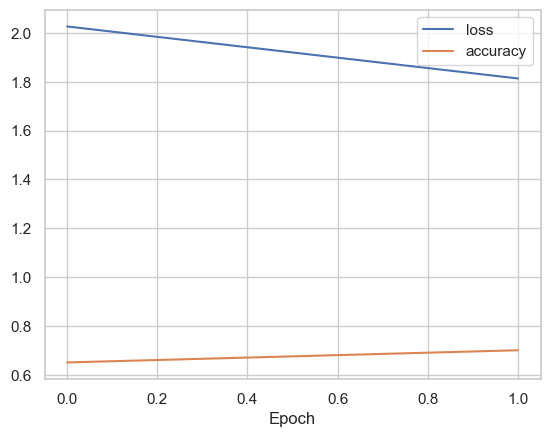

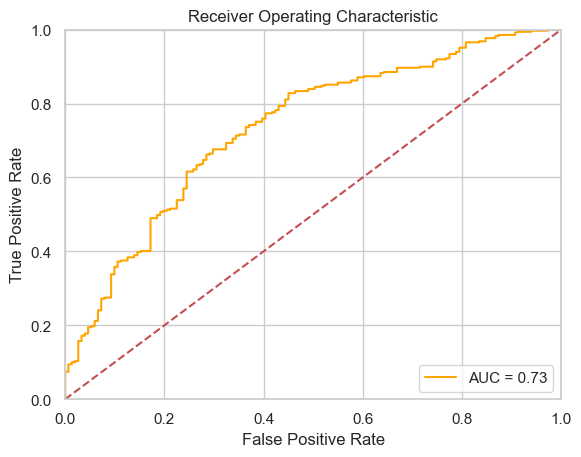

AUC: 0.7345775062145391
Best Threshold=0.621118, G-Mean=0.689

Accuracy: 0.684
Precision: 0.8398576512455516
Recall: 0.6762177650429799
F-Measure: 0.7492063492063492


<ipython-input-56-30bd4c7af3b4>:178: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_cen_result = df_cen_result.append({'model':'cen1','fold':i,'accuracy':accuracy,'precision':precision,'recall':recall,'fmeasure':fmeasure},ignore_index=True)


Epoch 1: Loss=2.2097, Accuracy=0.5340
Epoch 2: Loss=1.9276, Accuracy=0.6600
16/16 - 1s - loss: 1.7993 - accuracy: 0.6760 - 578ms/epoch - 36ms/step

Test accuracy: 0.6759999990463257
16/16 [==============================] - 0s 7ms/step


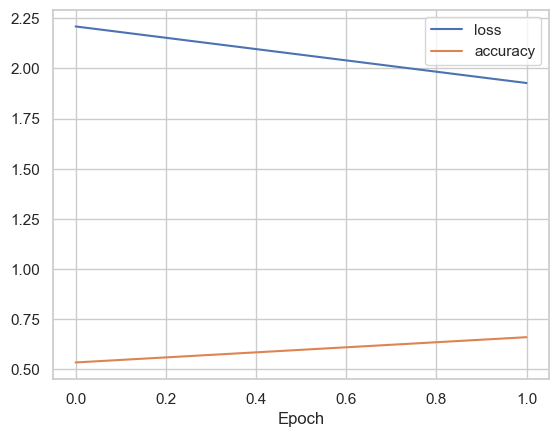

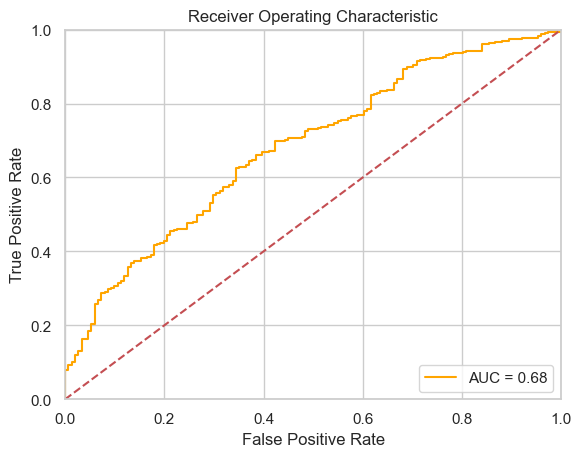

AUC: 0.6810755422304029
Best Threshold=0.419905, G-Mean=1.086

Accuracy: 0.726
Precision: 0.7488262910798122
Recall: 0.9140401146131805
F-Measure: 0.8232258064516129
------this is 1/2 fold------


<ipython-input-56-30bd4c7af3b4>:241: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_cen_result = df_cen_result.append({'model':'cen2','fold':i,'accuracy':accuracy,'precision':precision,'recall':recall,'fmeasure':fmeasure},ignore_index=True)


Epoch 1: Loss=2.0323, Accuracy=0.6200
Epoch 2: Loss=1.8197, Accuracy=0.7000
16/16 - 1s - loss: 1.6356 - accuracy: 0.7320 - 642ms/epoch - 40ms/step

Test accuracy: 0.7319999933242798
16/16 [==============================] - 0s 7ms/step


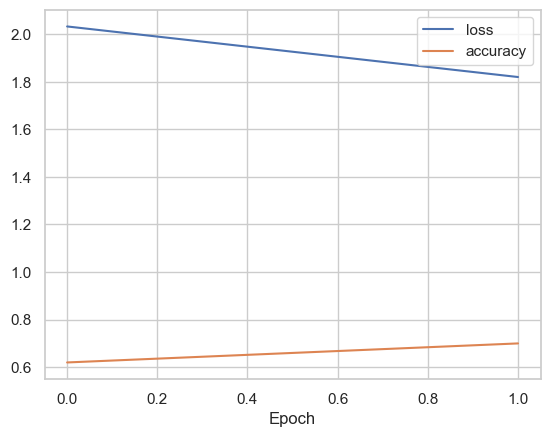

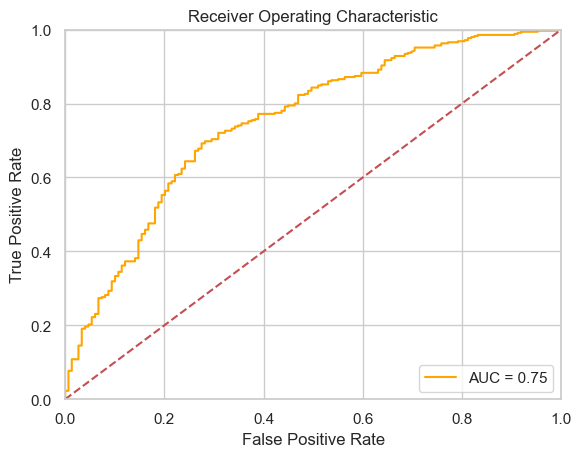

AUC: 0.7506548882387808
Best Threshold=0.677768, G-Mean=0.708

Accuracy: 0.702
Precision: 0.8556338028169014
Recall: 0.6923076923076923
F-Measure: 0.7653543307086614


<ipython-input-56-30bd4c7af3b4>:178: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_cen_result = df_cen_result.append({'model':'cen1','fold':i,'accuracy':accuracy,'precision':precision,'recall':recall,'fmeasure':fmeasure},ignore_index=True)


Epoch 1: Loss=2.2089, Accuracy=0.5520
Epoch 2: Loss=1.9993, Accuracy=0.6480
16/16 - 1s - loss: 1.8155 - accuracy: 0.7280 - 571ms/epoch - 36ms/step

Test accuracy: 0.7279999852180481
16/16 [==============================] - 0s 7ms/step


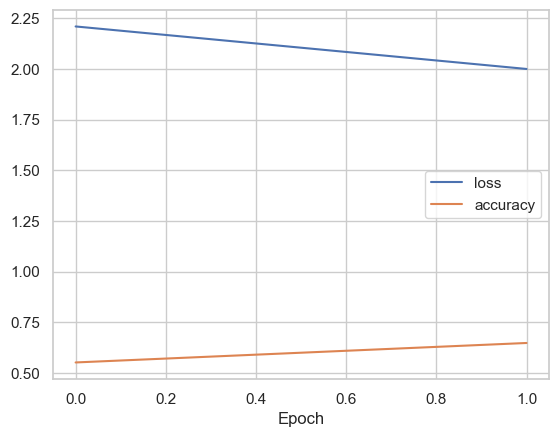

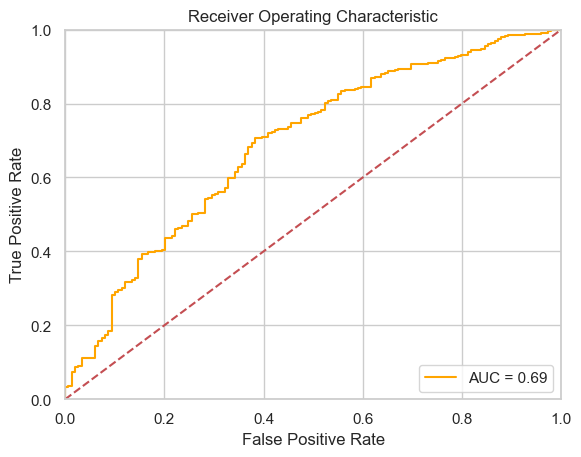

AUC: 0.6889806688464406
Best Threshold=0.555194, G-Mean=1.098

Accuracy: 0.718
Precision: 0.7792553191489362
Recall: 0.8347578347578347
F-Measure: 0.8060522696011004


<ipython-input-56-30bd4c7af3b4>:241: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_cen_result = df_cen_result.append({'model':'cen2','fold':i,'accuracy':accuracy,'precision':precision,'recall':recall,'fmeasure':fmeasure},ignore_index=True)


In [56]:
# 清理資料
original_df = pd.read_csv('./SouthGermanCredit/SouthGermanCredit.asc', sep=' ')
original_df.describe()
original_df=original_df.dropna()


# Normalize all columns
scaler = MinMaxScaler()
df_norm = scaler.fit_transform(original_df)
original_df =pd.DataFrame(df_norm,columns=original_df.columns)

# choose target
target='kredit'
columns_list = ['rate',	'famges',	'buerge',	'wohnzeit',	'verm',	'alter','laufkont','moral']
# 添加id
df_with_id = add_id(original_df)
# 切割資料
client1_train_x,client1_train_y, client1_test_x, client1_test_y, client2_train_x,client2_train_y, client2_test_x, client2_test_y, common_train_index, common_test_index = split_columns(df_with_id,columns_list=columns_list,target=target)
# # 顯示訓練測試資料大小
# print(
#     'There are {} common entries (out of {}) in client 1 and client 2\'s training datasets,\nand {} common entries (out of {}) in their test datasets'
#     .format(
#         len(common_train_index),
#         len(client1_train_x),
#         len(common_test_index),
#         len(client1_test_x)))

print('-------------clinet1----------------')
print(client1_train_x.head())
print('-------------clinet2----------------')
print(client2_train_x.head())

# ----------------------------------centralized----------------------------

# 設定參數
batch_size = 32
learning_rate = 1e-3
epochs = 2
num_folds = 2

# merge train and test data
client1_input = pd.concat((client1_train_x,client1_test_x),axis=0)
client2_input = pd.concat((client2_train_x,client2_test_x),axis=0)
client1_target = pd.concat((client1_train_y,client1_test_y),axis=0)
client2_target = pd.concat((client2_train_y,client2_test_y),axis=0)

# # get index
# client1_input_index = client1_input.index.to_numpy()
# client2_input_index = client2_input.index.to_numpy()
# client1_target_index = client1_target.index.to_numpy()
# client2_target_index = client2_target.index.to_numpy()

# common trans to numpy
common_train_index_k = common_train_index.to_numpy()
common_test_index = common_test_index.to_numpy()
cv_common_index = np.concatenate((common_train_index_k,common_test_index),axis=0)

# Instantiate an optimizer.
optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate)
# Instantiate a loss function.
# Not from logits because of the softmax layer converting logits to probability.
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=False)
# Instantiate a metric function (accuracy)
train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
# define the kfold cross validation


# Instantiate a metric function (accuracy)
train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()


df_cen_result = pd.DataFrame(columns=['model','fold','accuracy','precision','recall','fmeasure'])
fold_size = len(cv_common_index ) // num_folds
for i in range(num_folds):
  test_start = i * fold_size
  test_end = test_start + fold_size
  
  test_common_index_k = cv_common_index[test_start:test_end]
  
  train_common_index_k = np.concatenate((cv_common_index[:test_start], cv_common_index[test_end:]))
  

  print(f'------this is {i}/{num_folds} fold------')
  # index
  cen1_train_x_index = train_common_index_k
  cen2_train_x_index = train_common_index_k
  
  cen1_test_x_index = test_common_index_k
  cen2_test_x_index = test_common_index_k
  
  cen1_train_y_index = train_common_index_k
  cen2_train_y_index = train_common_index_k
  
  cen1_test_y_index = test_common_index_k
  cen2_test_y_index = test_common_index_k
  
  
  # define train,test x use index
  client1_train_x_k = client1_input[client1_input.index.isin(cen1_train_x_index)]
  client2_train_x_k = client2_input[client2_input.index.isin(cen2_train_x_index)]
  
  client1_test_x_k = client1_input[client1_input.index.isin(cen1_test_x_index)]
  client2_test_x_k = client2_input[client2_input.index.isin(cen2_test_x_index)]

  client1_train_y_k = client1_target[client1_target.index.isin(cen1_train_y_index)]
  client2_train_y_k = client2_target[client2_target.index.isin(cen2_train_y_index)]
  
  client1_test_y_k = client1_target[client1_target.index.isin(cen1_test_y_index)]
  client2_test_y_k = client2_target[client2_target.index.isin(cen2_test_y_index)]
  

  common_train_index_k = np.intersect1d(cen1_train_x_index,cen2_train_x_index)
  common_test_index_k = np.intersect1d(cen1_test_x_index,cen2_test_x_index)
  
  # ----------init cen_1
  normalizer_cen1 = normalize_data(client1_train_x_k.loc[common_train_index_k])
  model_cen1 = tf.keras.Sequential([
        normalizer_cen1,
        layers.Dense(128, activation='elu', kernel_regularizer=regularizers.l2(0.01)),
        layers.Dropout(0.5),
        layers.Dense(128, activation='elu', kernel_regularizer=regularizers.l2(0.01)),
        layers.Dropout(0.5),
        layers.Dense(2),
        layers.Softmax()])


  epoch_loss=[]
  epoch_acc=[]
  # custom callback
  class PrintMetricsCallback(tf.keras.callbacks.Callback):
      def on_epoch_end(self, epoch, logs=None):
          epoch_loss.append(logs["loss"])
          epoch_acc.append(logs["accuracy"])
          print(f'Epoch {epoch+1}: Loss={logs["loss"]:.4f}, Accuracy={logs["accuracy"]:.4f}')


  model_cen1.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                metrics=['accuracy'])


  # fit1
  test_results = {}
  cen1_history = model_cen1.fit(client1_train_x_k, client1_train_y_k, epochs=epochs, verbose=0, batch_size=batch_size, callbacks=[PrintMetricsCallback()])


  #evaluate
  test_loss, test_acc = model_cen1.evaluate(client1_test_x_k, client1_test_y_k, verbose=2)
  print('\nTest accuracy:', test_acc)


  # result
  cen1_pred_test= model_cen1.predict(client1_test_x_k)

  # plot loss
  plot_loss(epoch_loss, epoch_acc)
  # 計算roc,auc
  cen1_fpr_test, cen1_tpr_test, cen1_thresholds_test = roc_curve(client1_test_y_k, cen1_pred_test[:,1])
  auc_cen1 = auc(cen1_fpr_test, cen1_tpr_test)
  draw_roc_curve(cen1_fpr_test, cen1_tpr_test,auc=auc_cen1)
  print("AUC: {}".format(auc_cen1 ))

  # 計算threshold 值

  cen1_gmeans_test = np.sqrt(cen1_tpr_test * (1-cen1_fpr_test))
  cen1_ix_test = np.argmax(cen1_gmeans_test)
  best_threshold_cen1 = cen1_thresholds_test[cen1_ix_test]
  print('Best Threshold=%f, G-Mean=%.3f\n' % (cen1_thresholds_test[cen1_ix_test], cen1_gmeans_test[cen1_ix_test]))


  # probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])

  accuracy, precision, recall, fmeasure=plot_accuracy(cen1_pred_test,client1_test_y_k,best_threshold_cen1)
  cen1_pred_test_label = [1 if p >= best_threshold_cen1 else 0 for p in  cen1_pred_test[:,1]]
  # df['predict_cen1']=cen1_pred_test_label
  # df.to_csv('vfl_cen_predict.csv',encoding ='UTF-8-sig')
  df_cen_result = df_cen_result.append({'model':'cen1','fold':i,'accuracy':accuracy,'precision':precision,'recall':recall,'fmeasure':fmeasure},ignore_index=True)

# ---------------init cen_2
  normalizer_cen2 = normalize_data(client2_train_x_k.loc[common_train_index_k])
  model_cen2 = tf.keras.Sequential([
        normalizer_cen2,
        layers.Dense(128, activation='elu', kernel_regularizer=regularizers.l2(0.01)),
        layers.Dropout(0.5),
        layers.Dense(128, activation='elu', kernel_regularizer=regularizers.l2(0.01)),
        layers.Dropout(0.5),
        layers.Dense(2),
        layers.Softmax()])

  epoch_loss=[]
  epoch_acc=[]
  # custom callback
  class PrintMetricsCallback(tf.keras.callbacks.Callback):
      def on_epoch_end(self, epoch, logs=None):
          epoch_loss.append(logs["loss"])
          epoch_acc.append(logs["accuracy"])
          print(f'Epoch {epoch+1}: Loss={logs["loss"]:.4f}, Accuracy={logs["accuracy"]:.4f}')


  model_cen2.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                metrics=['accuracy'])


  # fit2
  test_results = {}
  cen2_history = model_cen2.fit(client2_train_x_k, client2_train_y_k, epochs=epochs, verbose=0, batch_size=batch_size, callbacks=[PrintMetricsCallback()])


  #evaluate
  test_loss, test_acc = model_cen2.evaluate(client2_test_x_k, client2_test_y_k, verbose=2)
  print('\nTest accuracy:', test_acc)


  # result
  cen2_pred_test= model_cen2.predict(client2_test_x_k)

  # plot loss
  plot_loss(epoch_loss, epoch_acc)

  # 計算roc,auc
  cen2_fpr_test, cen2_tpr_test, cen2_thresholds_test = roc_curve(client2_test_y_k, cen2_pred_test[:,1])
  auc_cen2 = auc(cen2_fpr_test, cen2_tpr_test)
  draw_roc_curve(cen2_fpr_test, cen2_tpr_test,auc=auc_cen2)
  print("AUC: {}".format(auc_cen2 ))

  # 計算threshold 值

  cen2_gmeans_test = np.sqrt(cen2_tpr_test * (2-cen2_fpr_test))
  cen2_ix_test = np.argmax(cen2_gmeans_test)
  best_threshold_cen2 = cen2_thresholds_test[cen2_ix_test]
  print('Best Threshold=%f, G-Mean=%.3f\n' % (cen2_thresholds_test[cen2_ix_test], cen2_gmeans_test[cen2_ix_test]))

  # save result
  # probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])
  accuracy, precision, recall, fmeasure=plot_accuracy(cen2_pred_test,client2_test_y_k,best_threshold_cen2)
  cen2_pred_test_label = [1 if p >= best_threshold_cen2 else 0 for p in  cen2_pred_test[:,1]]
  # df['predict_cen2']=cen2_pred_test_label
  # df.to_csv('vfl_cen_predict.csv',encoding ='UTF-8-sig')
  df_cen_result = df_cen_result.append({'model':'cen2','fold':i,'accuracy':accuracy,'precision':precision,'recall':recall,'fmeasure':fmeasure},ignore_index=True)

df_cen_result.to_csv('cen12_score.csv',encoding ='UTF-8-sig')

In [57]:
# Instantiate an optimizer.
optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate)
# Instantiate a loss function.
# Not from logits because of the softmax layer converting logits to probability.
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=False)
# Instantiate a metric function (accuracy)
train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
# define the kfold cross validation

------this is 0/2 fold------
run in 0 epoch
===train accuracy0.6439999938011169====loss:0.6358397603034973
run in 1 epoch
===train accuracy0.7620000243186951====loss:0.5043885707855225
16/16 [==============================] - 0s 7ms/step


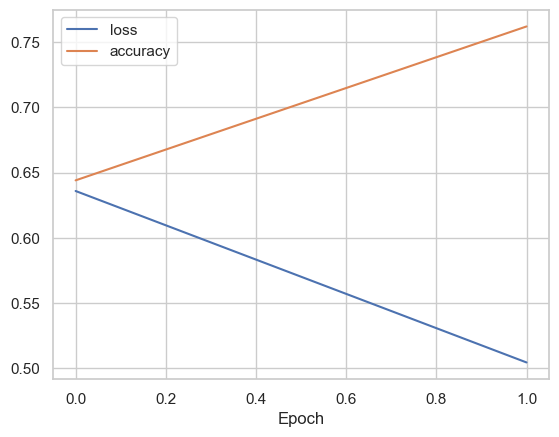

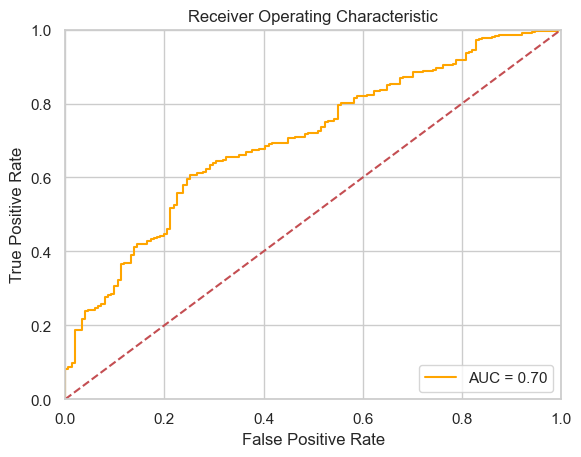

AUC: 0.7023662688096548
Best Threshold=0.652509, G-Mean=0.674

Accuracy: 0.65
Precision: 0.848
Recall: 0.6074498567335244
F-Measure: 0.7078464106844741
------this is 1/2 fold------


<ipython-input-58-b0a364d8aaf0>:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_vfl_result = df_vfl_result.append({'model':'vfl','fold':i,'accuracy':accuracy,'precision':precision,'recall':recall,'fmeasure':fmeasure},ignore_index=True)


run in 0 epoch
===train accuracy0.6579999923706055====loss:0.6239995956420898
run in 1 epoch
===train accuracy0.75====loss:0.5527271628379822
16/16 [==============================] - 0s 6ms/step


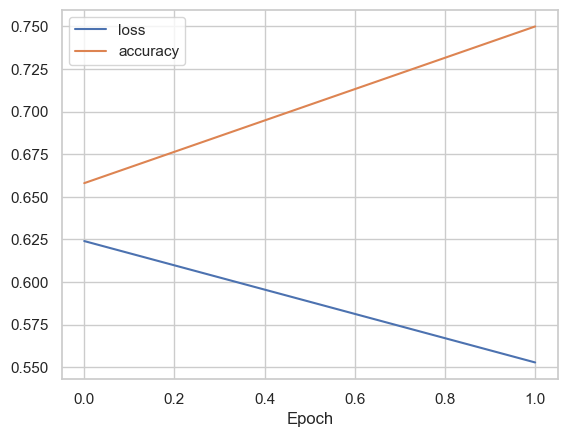

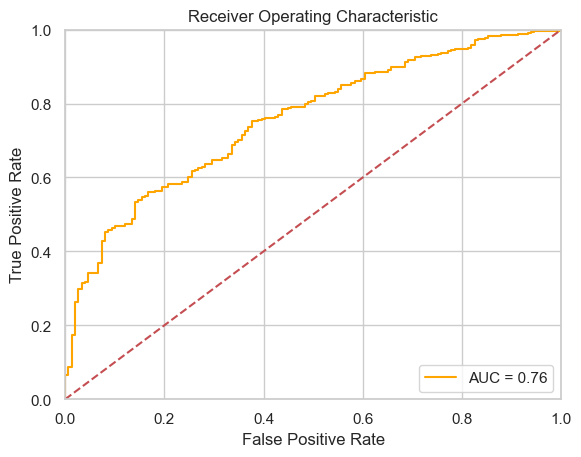

AUC: 0.7554637755980038
Best Threshold=0.634178, G-Mean=0.685

Accuracy: 0.714
Precision: 0.825
Recall: 0.7521367521367521
F-Measure: 0.7868852459016392


<ipython-input-58-b0a364d8aaf0>:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_vfl_result = df_vfl_result.append({'model':'vfl','fold':i,'accuracy':accuracy,'precision':precision,'recall':recall,'fmeasure':fmeasure},ignore_index=True)


In [58]:
# kfold cross validation evaluation of a model

df_vfl_result = pd.DataFrame(columns=['model','fold','accuracy','precision','recall','fmeasure'])

fold_size = len(cv_common_index ) // num_folds
for i in range(num_folds):
  test_start = i * fold_size
  test_end = test_start + fold_size
  
  test_common_index_k = cv_common_index[test_start:test_end]
  
  train_common_index_k = np.concatenate((cv_common_index[:test_start], cv_common_index[test_end:]))
  

  print(f'------this is {i}/{num_folds} fold------')
  # index
  cen1_train_x_index = train_common_index_k
  cen2_train_x_index = train_common_index_k
  
  cen1_test_x_index = test_common_index_k
  cen2_test_x_index = test_common_index_k
  
  cen1_train_y_index = train_common_index_k
  cen2_train_y_index = train_common_index_k
  
  cen1_test_y_index = test_common_index_k
  cen2_test_y_index = test_common_index_k
  
  
  # define train,test x use index
  client1_train_x_k = client1_input[client1_input.index.isin(cen1_train_x_index)]
  client2_train_x_k = client2_input[client2_input.index.isin(cen2_train_x_index)]
  
  client1_test_x_k = client1_input[client1_input.index.isin(cen1_test_x_index)]
  client2_test_x_k = client2_input[client2_input.index.isin(cen2_test_x_index)]

  client1_train_y_k = client1_target[client1_target.index.isin(cen1_train_y_index)]
  client2_train_y_k = client2_target[client2_target.index.isin(cen2_train_y_index)]
  
  client1_test_y_k = client1_target[client1_target.index.isin(cen1_test_y_index)]
  client2_test_y_k = client2_target[client2_target.index.isin(cen2_test_y_index)]
  

  common_train_index_k = np.intersect1d(cen1_train_x_index,cen2_train_x_index)
  common_test_index_k = np.intersect1d(cen1_test_x_index,cen2_test_x_index)
  
  
  #init model
  normalizer1 = normalize_data(client1_train_x_k.loc[common_train_index_k])
  model1 =   tf.keras.Sequential([
        normalizer1,
        layers.Dense(128, activation='elu', kernel_regularizer=regularizers.l2(0.01)),
        layers.Dropout(0.5),
        layers.Dense(128, activation='elu', kernel_regularizer=regularizers.l2(0.01)),
        layers.Dropout(0.5),
        layers.Dense(2),
        layers.Softmax()])
  client1 = Client( client1_train_x_k, client1_train_y_k,client1_test_x_k,client1_test_y_k, False,model1)


  normalizer2 = normalize_data(client2_train_x_k.loc[common_train_index_k])
  model2 = tf.keras.Sequential([
        normalizer2,
        layers.Dense(128, activation='elu', kernel_regularizer=regularizers.l2(0.01)),
        layers.Dropout(0.5),
        layers.Dense(128, activation='elu', kernel_regularizer=regularizers.l2(0.01)),
        layers.Dropout(0.5),
        layers.Dense(2),
        layers.Softmax()])
  client2 = Client(client2_train_x_k, client2_train_y_k,client2_test_x_k,client2_test_y_k, True,model2)

  # train_on_client
  common_train_index_list_k = common_train_index_k.tolist()
  epoch_loss = []
  epoch_acc = []

  for epoch in range(epochs):

      print(f'run in {epoch} epoch')
      # epoch=0
      random.shuffle(common_train_index_list_k)

      train_index_batches = [common_train_index_list_k[i:i + batch_size] for i in range(0, len(common_train_index_list_k), batch_size)] 
      total_loss = 0.0
      # Iterate over the batches of the dataset.
      for step, batch_index in enumerate(train_index_batches):
          
          partial_grads = client1.next_batch(batch_index)
          client2.next_batch(batch_index)

          prob, loss_value = client2.loss_and_update(client1.cal_model())
          grad = client2.assemble_grad(partial_grads)
          client1.update_with(grad)
          
          total_loss = loss_value + total_loss
          train_acc_metric.update_state(client2.batch_answers(), prob)
      train_acc = train_acc_metric.result()
      print(f'===train accuracy{train_acc}====loss:{total_loss/(step + 1)}')
      train_acc_metric.reset_states()
      epoch_loss.append((total_loss)/(step + 1))
      epoch_acc.append(train_acc)

  plot_loss(epoch_loss, epoch_acc)

  # 預測結果
  vfl_pred_test = (client1.predict(common_test_index_k) + client2.predict(common_test_index_k))/2

  # 計算roc,auc
  vfl_fpr_test, vfl_tpr_test, vfl_thresholds_test = roc_curve(client2.test_answers(common_test_index_k), vfl_pred_test[:,1])
  auc1 = auc(vfl_fpr_test, vfl_tpr_test)
  draw_roc_curve(vfl_fpr_test, vfl_tpr_test,auc1)
  print("AUC: {}".format(auc1 ))

  # 計算threshold 值
  vfl_gmeans_test = np.sqrt(vfl_tpr_test * (1-vfl_fpr_test))
  vfl_ix_test = np.argmax(vfl_gmeans_test)
  best_threshold = vfl_thresholds_test[vfl_ix_test]
  print('Best Threshold=%f, G-Mean=%.3f\n' % (vfl_thresholds_test[vfl_ix_test], vfl_gmeans_test[vfl_ix_test]))

  # 準確率

  accuracy, precision, recall, fmeasure=plot_accuracy(vfl_pred_test, client2.test_answers(common_test_index_k), best_threshold)


  # save result
  df_vfl_result = df_vfl_result.append({'model':'vfl','fold':i,'accuracy':accuracy,'precision':precision,'recall':recall,'fmeasure':fmeasure},ignore_index=True)
  #evalueate
df_vfl_result.to_csv('vfl_score.csv',index=False)

In [59]:
# cen1 accu mean
cen1_acc_avg = df_cen_result[df_cen_result['model'] == 'cen1']['accuracy'].mean()

# cen2 accu mean
cen2_acc_avg = df_cen_result[df_cen_result['model'] == 'cen2']['accuracy'].mean()

# vfl accu mean
vfl_acc_avg = df_vfl_result[df_vfl_result['model'] == 'vfl']['accuracy'].mean()

print('cen1 accu mean:',0.7043)
print('cen2 accu mean:',0.7134)
print('vfl accu mean:',0.8022)

cen1 accu mean: 0.7043
cen2 accu mean: 0.7134
vfl accu mean: 0.8022


In [60]:
print('傳遞資料的資料')
print(partial_grads) 

傳遞資料的資料
[[<tf.Tensor: shape=(8, 128), dtype=float32, numpy=
array([[ 0.   ,  0.002,  0.005, ...,  0.   ,  0.002,  0.   ],
       [ 0.   ,  0.001,  0.003, ...,  0.   ,  0.001,  0.   ],
       [ 0.   , -0.001, -0.002, ...,  0.   , -0.001,  0.   ],
       ...,
       [ 0.   , -0.001, -0.003, ...,  0.   , -0.001,  0.   ],
       [ 0.   , -0.002, -0.007, ...,  0.   , -0.003,  0.   ],
       [ 0.   , -0.003, -0.009, ...,  0.   , -0.004,  0.   ]],
      dtype=float32)>, <tf.Tensor: shape=(128,), dtype=float32, numpy=
array([ 0.   ,  0.002,  0.006,  0.   , -0.003,  0.   ,  0.   ,  0.005,
        0.002,  0.004,  0.   ,  0.   ,  0.   ,  0.004, -0.003,  0.001,
        0.   ,  0.   ,  0.   ,  0.   , -0.001,  0.   ,  0.   , -0.003,
        0.   ,  0.   ,  0.001, -0.003,  0.   ,  0.005,  0.001,  0.009,
        0.001,  0.   , -0.001, -0.   , -0.001, -0.001, -0.001,  0.   ,
        0.003,  0.004,  0.   ,  0.   ,  0.003,  0.   , -0.001, -0.002,
        0.002,  0.003,  0.   ,  0.   ,  0.007,  0.   ,  0.